## Investigate the synthetic data generated from TVAE


We load the original Adult data as well, such that we can compare to the "ground truth".

In [1]:
import numpy as np
import pandas as pd
import random

import sys
import os
# Tricks for loading data and libraries from parent directories. 
parent = os.path.abspath("..")
grandparent = os.path.abspath("../..")
sys.path.insert(1, parent)
sys.path.insert(2, grandparent)
print(sys.path)

# Custom styles and sizing for matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("../tex.mplstyle")
from plotting.plotting_utils import set_size

from sklearn import metrics # plot_roc_curve.

from Data import Data, CustomDataset, ToTensor

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10, 10)


# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 25

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

['/home/ajo/gitRepos/master_thesis/plotting/AD', '/home/ajo/gitRepos/master_thesis/plotting', '/home/ajo/gitRepos/master_thesis', '/home/ajo/anaconda3/envs/master/lib/python38.zip', '/home/ajo/anaconda3/envs/master/lib/python3.8', '/home/ajo/anaconda3/envs/master/lib/python3.8/lib-dynload', '', '/home/ajo/.local/lib/python3.8/site-packages', '/home/ajo/anaconda3/envs/master/lib/python3.8/site-packages']


In [2]:
# Set seeds for reproducibility. 
seed = 1234
np.random.seed(seed)
random.seed(seed)

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# Load the real data into the scope. 
training = pd.read_csv("../../splitted_data/AD/AD_train.csv", index_col = 0)
test = pd.read_csv("../../splitted_data/AD/AD_test.csv", index_col = 0)
valid = pd.read_csv("../../splitted_data/AD/AD_valid.csv", index_col = 0)
data = {"Train":training, "Test":test, "Valid":valid}

Data_object = Data(data, cat_features = categorical_features, num_features = numerical_features,
                       seed = seed, already_splitted_data=True, scale_version="quantile", valid = True)
X_train, y_train = Data_object.get_training_data()
X_test, y_test = Data_object.get_test_data()
print(X_train.shape)
real_data = Data_object.get_original_data()
print(real_data.shape)

# Load the synthetic data into the scope. 
synthetic_samples = pd.read_csv("../../synthetic_data/AD_TVAE"+str(seed)+".csv", index_col = 0)
print(synthetic_samples.shape)

print(synthetic_samples.iloc[:,-1].value_counts(normalize = True))
print(Data_object.get_proportion_of_response())

(36177, 13)
(45222, 14)
(45222, 14)
0    0.764119
1    0.235881
Name: y, dtype: float64
0    0.752156
1    0.247844
Name: y, dtype: float64


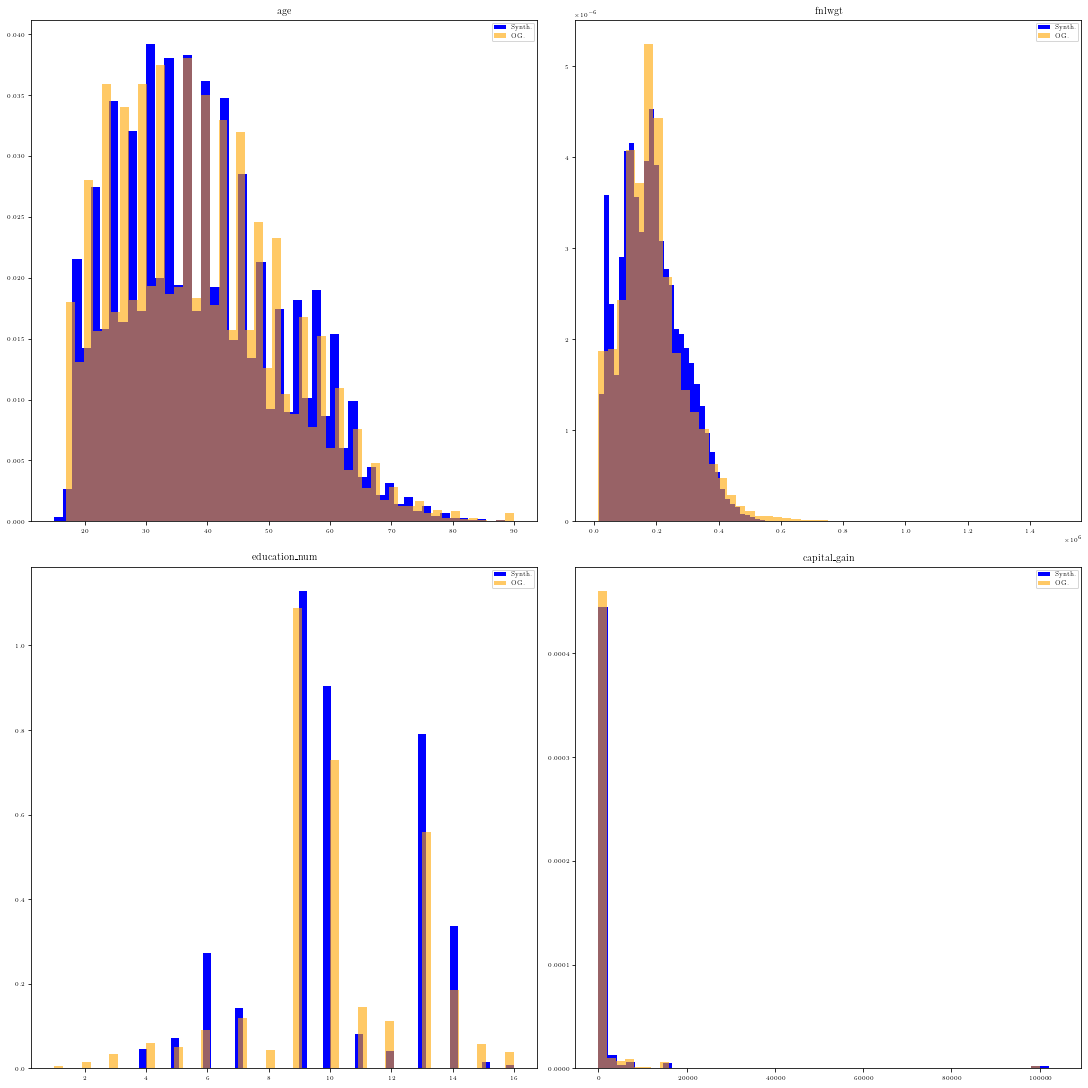

In [3]:
fig, axs = plt.subplots(2,2, figsize = (15,15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(real_data[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

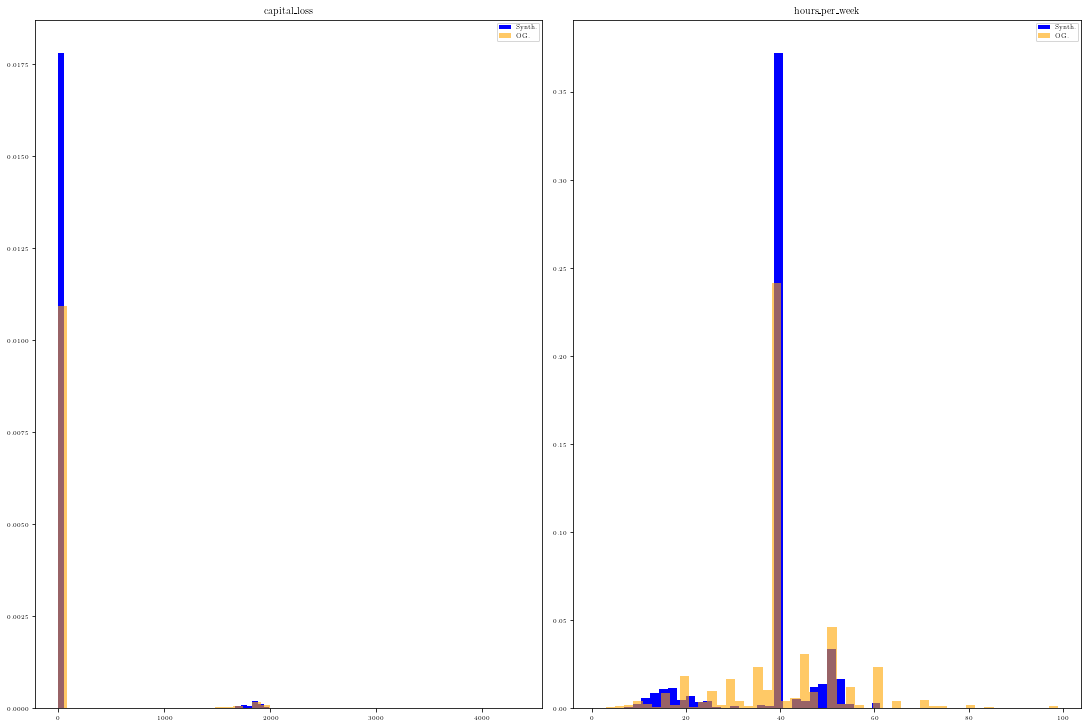

In [4]:
fig, axs = plt.subplots(1,2, figsize = (15,10))
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(real_data[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

Text(0.5, 1.0, 'True Correlation')

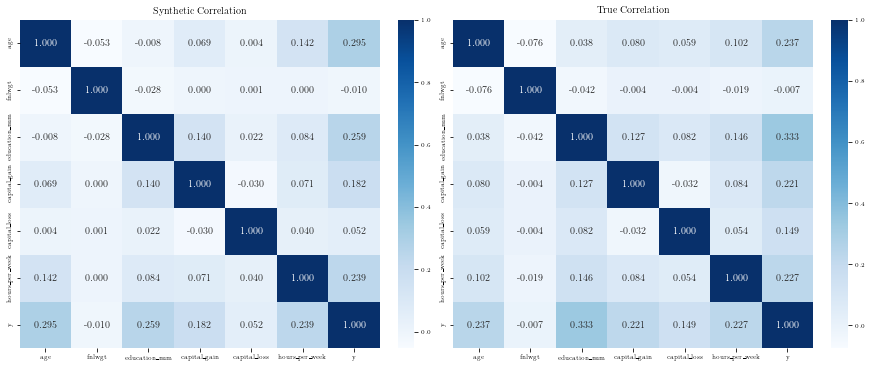

In [5]:
synthetic_corr = synthetic_samples.corr()
true_corr = real_data.corr()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")

Text(0.5, 1.0, 'Abs. Difference Correlation')

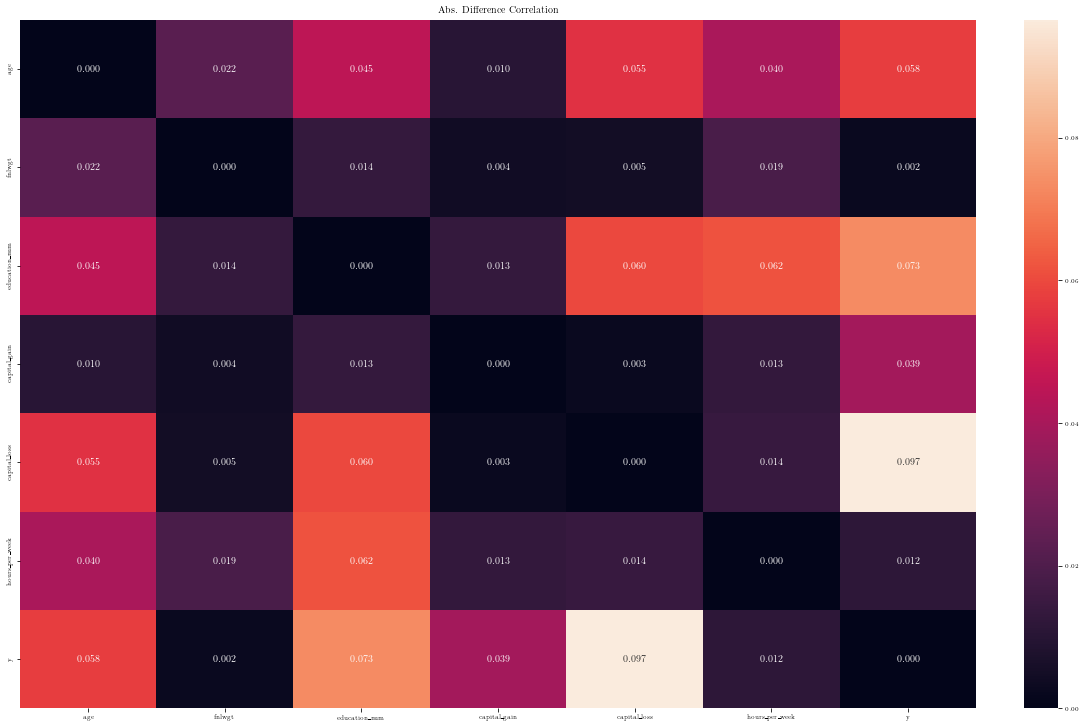

In [6]:
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax)
ax.set_title("Abs. Difference Correlation")

Text(0.5, 1.0, 'Relative (%) Difference in Statistics')

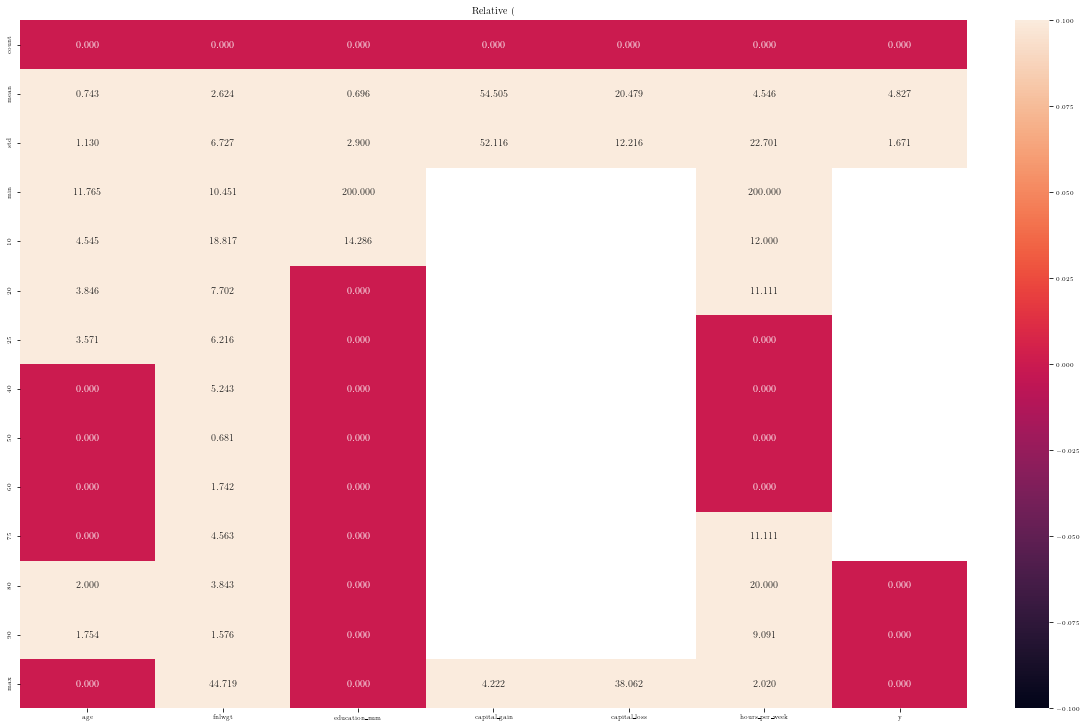

In [7]:
percentiles = [0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9]
desc_synth = synthetic_samples.describe(percentiles = percentiles)
desc_true = real_data.describe(percentiles = percentiles)

fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.divide(np.abs(desc_synth - desc_true),desc_true)*100, annot = True, fmt = ".3f", ax = ax)
ax.set_title("Relative (%) Difference in Statistics")

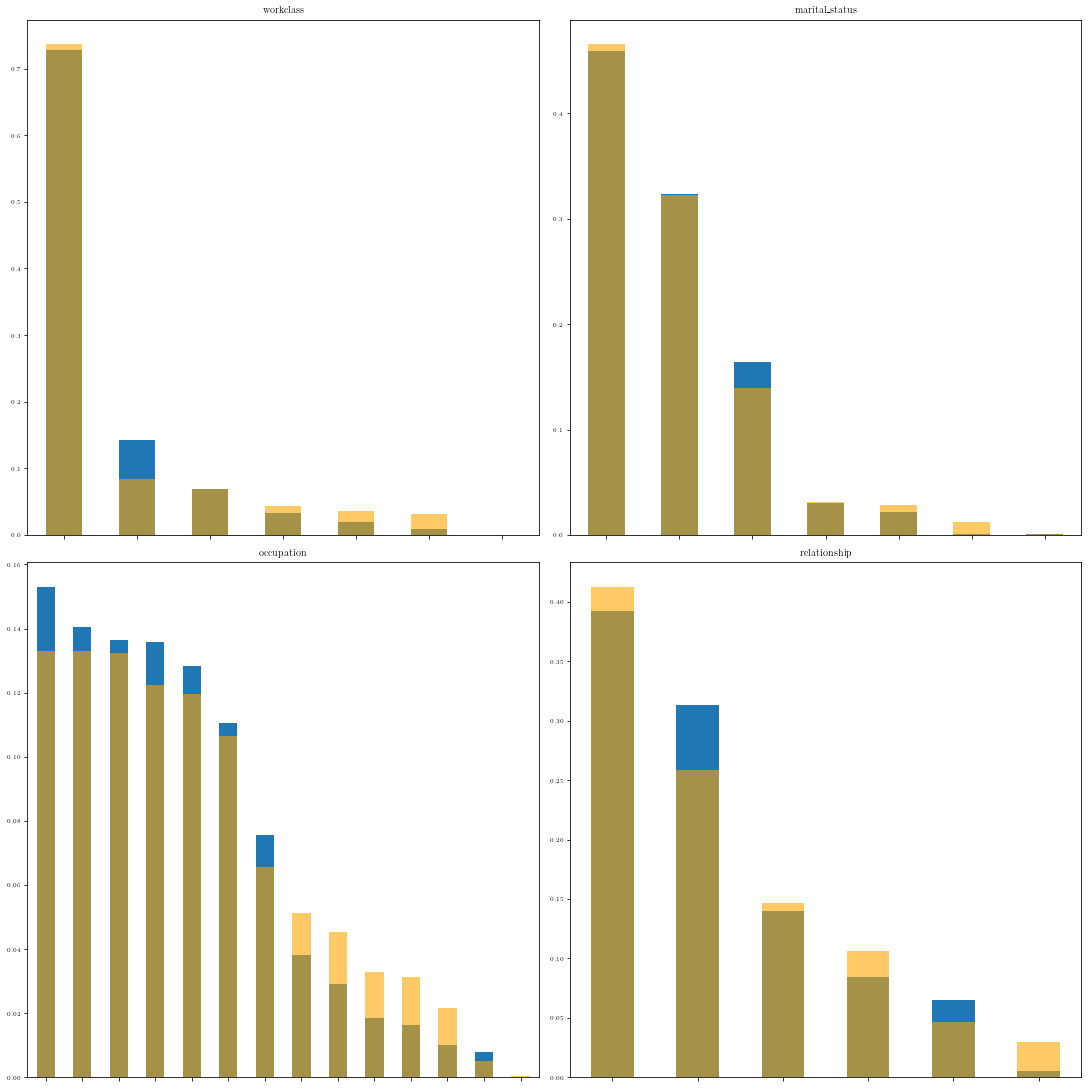

In [8]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
    ax.xaxis.set_ticklabels([])
plt.tight_layout()

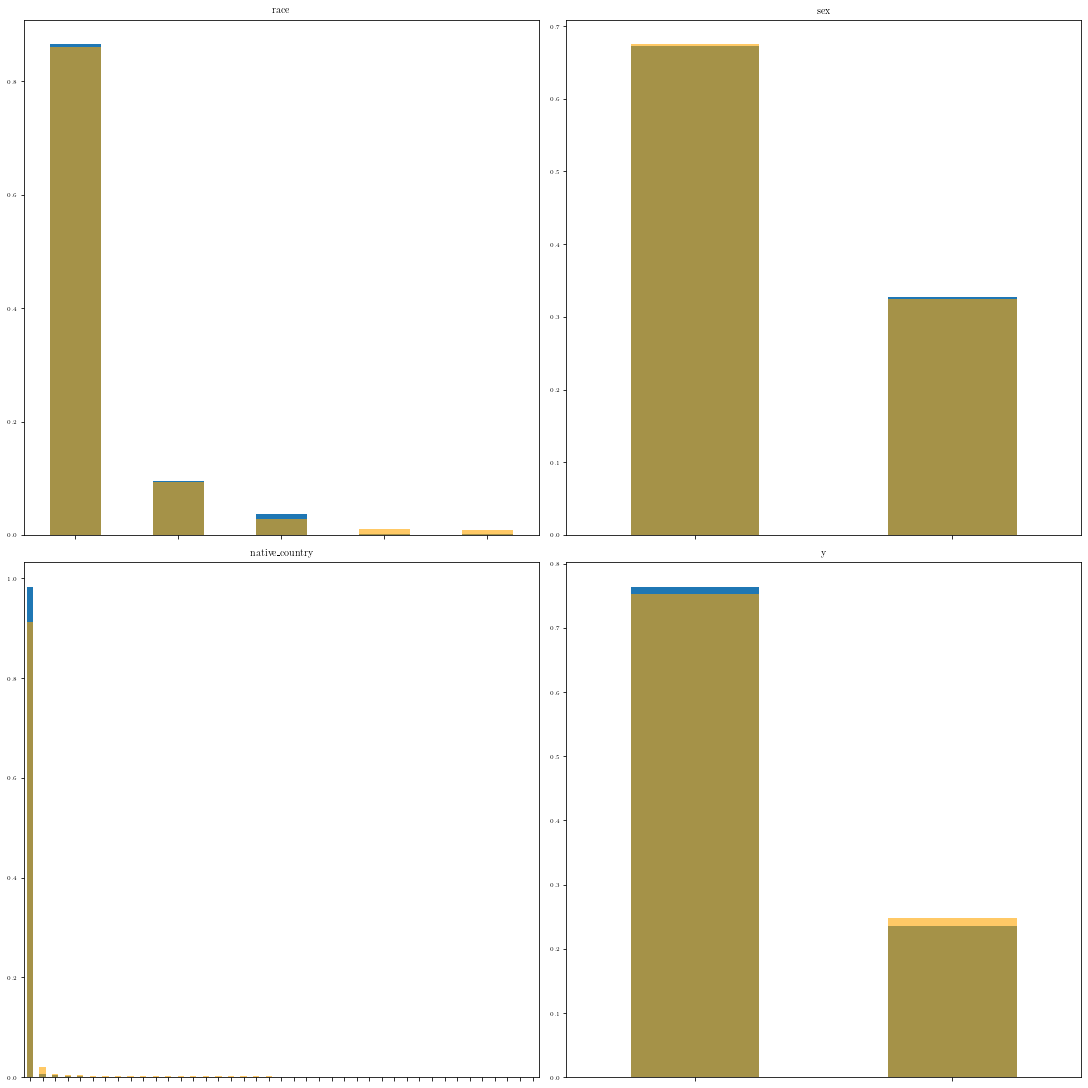

In [9]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
categorical_features += ["y"]
for idx, ax in enumerate(axs, start = 4):
    if idx > len(categorical_features)-1:
        break
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
    ax.xaxis.set_ticklabels([])
plt.tight_layout()

In [10]:
# Calculate correlations between categorical variables
# using Theil's U statistic.
# https://en.wikipedia.org/wiki/Uncertainty_coefficient
from dython.nominal import associations

synth2 = synthetic_samples.copy()
adult2 = real_data.copy()

adult2 = adult2[synth2.columns.tolist()]

synthetic_corr = associations(synth2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

true_corr = associations(adult2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

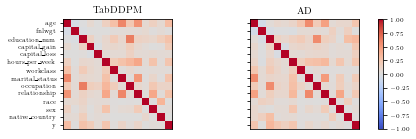

In [11]:
# plot correlations between -1 and 1.
fig, ax = plt.subplots(1,2, figsize = set_size(subplots = (1,2)))
ax[0].imshow(synthetic_corr, cmap = sns.color_palette("coolwarm", as_cmap=True), vmin = -1, vmax = 1)
ax[0].set_title("TabDDPM")
ax[0].set_yticks(range(len(synth2.columns.tolist())))
ax[0].yaxis.set_ticklabels(synth2.columns.tolist())
ax[0].xaxis.set_ticklabels([])
ax[0].tick_params(which='major', bottom=False, left=True)
im = ax[1].imshow(true_corr, cmap = sns.color_palette("coolwarm", as_cmap=True), vmin = -1, vmax = 1)
ax[1].set_title("AD")
ax[1].xaxis.set_ticklabels([])
ax[1].set_yticks(range(len(synth2.columns.tolist())))
ax[1].yaxis.set_ticklabels([])
ax[1].tick_params(which='major', bottom=False, left=True)
fig.colorbar(im, ax=ax.ravel().tolist())
#plt.tight_layout()
#plt.savefig("plots/AD/TabDDPM_Corr_AD.pdf", format="pdf", bbox_inches = "tight") 

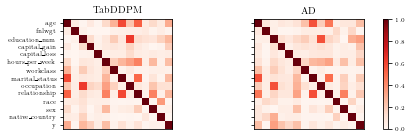

In [12]:
# or plot absolute values (only focus on the strength).
# I think I prefer this one. 
fig, ax = plt.subplots(1,2, figsize = set_size(subplots = (1,2)))
ax[0].imshow(abs(synthetic_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax[0].set_title("TabDDPM")
ax[0].xaxis.set_ticklabels([])
ax[0].set_yticks(range(len(synth2.columns.tolist())))
ax[0].yaxis.set_ticklabels(synth2.columns.tolist())
ax[0].tick_params(which='major', bottom=False, left=True)
im = ax[1].imshow(abs(true_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax[1].set_title("AD")
ax[1].xaxis.set_ticklabels([])
ax[1].set_yticks(range(len(synth2.columns.tolist())))
ax[1].yaxis.set_ticklabels([])
ax[1].tick_params(which='major', bottom=False, left=True)
fig.colorbar(im, ax=ax.ravel().tolist())
#plt.tight_layout()
#plt.savefig("plots/AD/TabDDPM_Abs_Corr_AD.pdf", format="pdf", bbox_inches = "tight") 

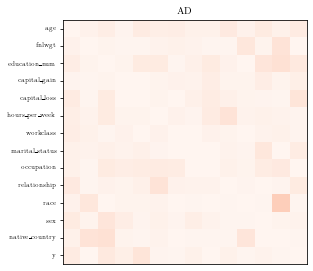

In [13]:
# or plot absolute difference between correlations of both data sets (true - synthetic).
# This is also very nice.
fig, ax = plt.subplots(1,1, figsize = set_size())
ax.imshow(np.abs(true_corr - synthetic_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax.set_title("AD")
ax.xaxis.set_ticklabels([])
ax.set_yticks(range(len(synth2.columns.tolist())))
ax.yaxis.set_ticklabels(synth2.columns.tolist())
ax.tick_params(which='major', bottom=False, left=True)
plt.tight_layout()
#plt.savefig("plots/AD/TabDDPM_Abs_Diff_Corr_AD.pdf", format="pdf", bbox_inches = "tight")
#print(np.abs(true_corr - synthetic_corr))

Text(0.5, 1.0, 'True Correlation')

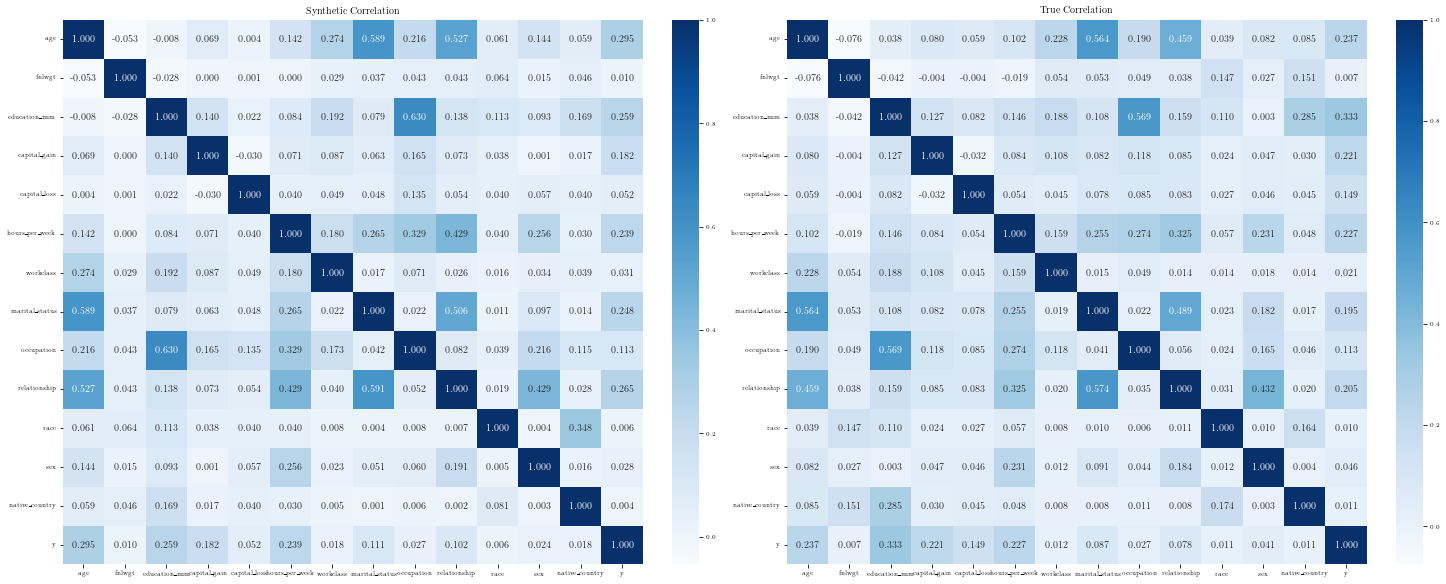

In [14]:
# Make sure that the features are in the same order. 
fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")

#plt.savefig("plots/AD/TabDDPM_Corr_AD.pdf", format="pdf", bbox_inches = "tight")  
#plt.tight_layout()

Text(0.5, 1.0, 'Abs. Difference Correlation')

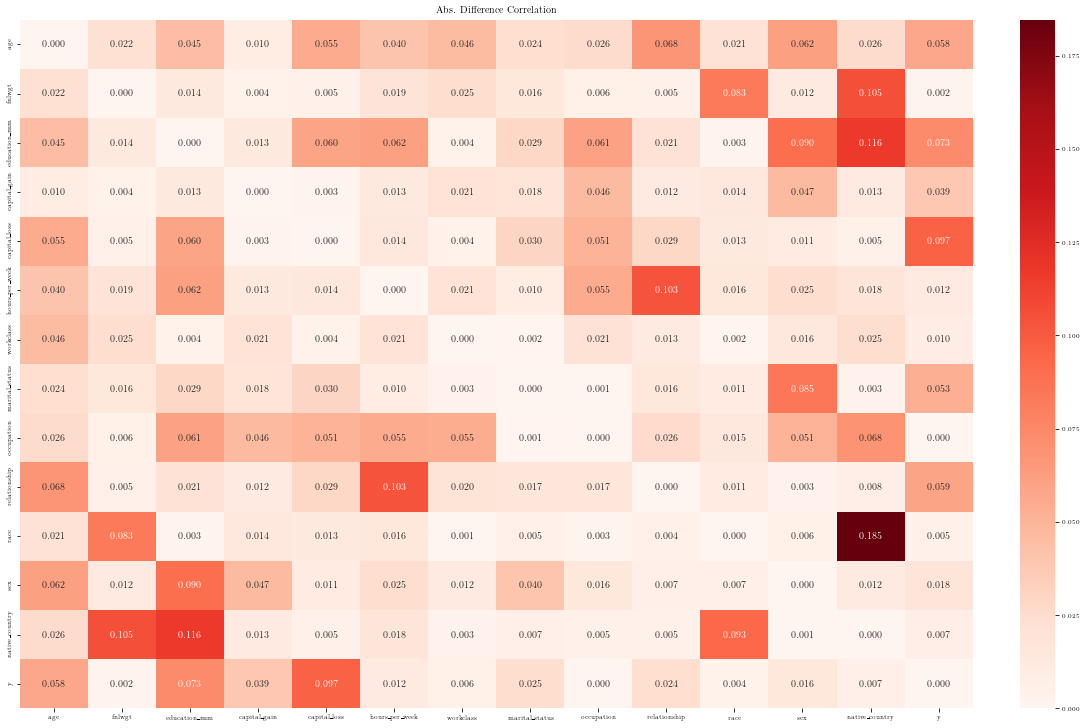

In [15]:
# Plot absolute difference between them.
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax, cmap = "Reds")
ax.set_title("Abs. Difference Correlation")
#plt.tight_layout()

In [16]:
# Calculate correlations between categorical and numerical variables,
# using the correlation Ratio.

In [17]:
# Good source:
# https://medium.com/the-researchers-guide/generate-numerical-correlation-and-nominal-association-plots-using-python-c8548aa4a663

In [18]:
# All the three are done automatically above!

## Make plots for thesis below

In [ ]:
fig, axes = plt.subplots(5,3, figsize = set_size(subplots = (5,3)))
axs = axes.ravel()
features = numerical_features + categorical_features
for idx, ax in enumerate(axs):
    if idx > len(features)-1:
        break
    if idx in range(len(numerical_features)):
        ax.hist(synthetic_samples[features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
        ax.hist(real_data[features[idx]], color = "orange", alpha = 0.6, density = True, label = "Real", bins = 50)
        #ax.legend()
        ax.title.set_text(features[idx])
    elif idx in range(len(numerical_features),len(numerical_features) + len(categorical_features)):
        (synthetic_samples[features[idx]].value_counts(normalize = True)).plot(kind='bar', ax = ax, color = "b", label = "Synth.")
        (real_data[features[idx]].value_counts(normalize = True)).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6, label = "Real")
        ax.title.set_text(features[idx])
        ax.xaxis.set_ticklabels([])
        #ax.legend()
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = "lower right")
axes[4,2].set_axis_off()
#plt.tight_layout()

#plt.savefig("../../plots/AD/TVAE_Qual_AD.pdf", format="pdf", bbox_inches = "tight")  
    